In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup as bs
import urllib, cStringIO
import urllib2
from PIL import Image
import pickle
from time import time
import re
import gzip
import os
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
from socket import error as SocketError
import errno
import boto3
import cPickle
import shutil

In [23]:
zap = pd.read_csv('zap.csv')

In [24]:
zap.shape

(26422, 10)

In [9]:
brand_dict = dict(zip(zap.brand_name.unique(),range(0,len(zap.brand_name.unique()))))
shoe_dict = dict(zip(zap.shoe_name.unique(),range(0,len(zap.shoe_name.unique()))))
color_dict = dict(zip(zap.colorway,zap.colorcode))

In [10]:
def img_name(row):
    brand = row['brand_name']
    shoe = row['shoe_name']
    color = row['colorway']
    return str(brand_dict[brand]) + '_' + str(shoe_dict[shoe]) + '_' + str(color_dict[color])
        

In [11]:
def img_fetch(url):
    try:
        sample = cStringIO.StringIO(urllib.urlopen(url).read())
        img = Image.open(sample)
        image_array = np.array(img)
        resized_image_array = cv2.resize(image_array, (224, 224))
        return resized_image_array
    except:
        pass

In [12]:
def img_dl(row):
    views = ['lateralfrontleft','heelview','toeview','medialfrontright','topview']
    row_imgs = map(lambda url: img_fetch(url), row[1][views].tolist())
    shoe_views = dict(zip(views, row_imgs))
    shoe_name = (img_name(row[1]))
    try:
        shoe_path = os.makedirs(shoe_name)
        for view in views:
            fname = view
            cPickle.dump(shoe_views[view], open(str(shoe_name)+'/'+fname, 'wb'))
         
    except:
        pass


In [13]:
def s3_upload(s3, row, bucket='capstoneshoes'):
    try:
        shoename = img_dl(row)
        shoe_name = img_name(row[1])
        for subdir, dirs, files in os.walk('./{}'.format(shoe_name)):
            for f in files:
                full_path = os.path.join(subdir, f)
                with open(full_path, 'rb') as data:
                    s3.put_object(Bucket=bucket,Key = full_path[len('./'):], Body = data)
                    print "Success! added {}".format(shoe_name)
        shutil.rmtree('{}'.format(shoe_name))
    except:
        pass


In [1]:
s3 = boto3.resource('s3')
for bucket in s3.buckets.all():
    print(bucket.name)

NameError: name 'boto3' is not defined

In [3]:
s3_connection = boto3.client('s3')
def zap_connect(x):
    return s3_upload(s3_connection, x)

In [17]:
import multiprocessing
from multiprocessing.pool import Pool

In [18]:
pool = Pool(processes=multiprocessing.cpu_count())

In [19]:
pool.map(zap_connect, list(zap.iterrows()))

[None, None, None, None]

In [2]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('capstoneshoes')
size = len(list(bucket.objects.all()))

In [2]:
loaded_data=pickle.load(open('/Users/Gene/Desktop/capstone/X_test_heelview/0_46_611465'))

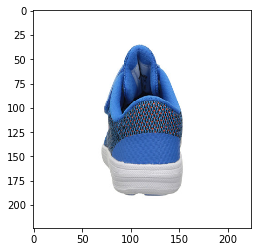

In [3]:
load